In [46]:
# import libraries
import os
os.environ['QT_QPA_PLATFORM']='offscreen'
import logging
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
def import_data(pth):
    '''
    returns dataframe for the csv found at pth

    input:
            pth: a path to the csv
    output:
            df: pandas dataframe
    '''	
    try:
        df = pd.read_csv(pth)
        logging.info('File {} has been succesfullly converted to csv'.format(pth))
        return df
    except Exception as e:
        logging.error('Error occurred when trying to convert file {} to csv: {} '.format(pth,e.message))


In [48]:
def perform_eda(df):
    '''
    perform eda on df and save figures to images folder
    input:
            df: pandas dataframe

    output:
            None
    '''
    #defining cat and nums columns
    cat_columns = [
        'Gender',
        'Education_Level',
        'Marital_Status',
        'Income_Category',
        'Card_Category'                
    ]

    quant_columns = [
        'Customer_Age',
        'Dependent_count', 
        'Months_on_book',
        'Total_Relationship_Count', 
        'Months_Inactive_12_mon',
        'Contacts_Count_12_mon', 
        'Credit_Limit', 
        'Total_Revolving_Bal',
        'Avg_Open_To_Buy', 
        'Total_Amt_Chng_Q4_Q1', 
        'Total_Trans_Amt',
        'Total_Trans_Ct', 
        'Total_Ct_Chng_Q4_Q1', 
        'Avg_Utilization_Ratio'
    ]
    column_name = set(cat_columns + quant_columns)

    #create EDA and save
    df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)
    plt.figure(figsize=(20,10)) 
    df['Churn'].hist();
    plt.savefig('images/eda/churn_hist.png')

    plt.figure(figsize=(20,10)) 
    df['Customer_Age'].hist();
    plt.savefig('images/eda/Customer_Age_hist.png')

    plt.figure(figsize=(20,10)) 
    df.Marital_Status.value_counts('normalize').plot(kind='bar');
    plt.savefig('images/eda/Marital_Status_bar.png')

    plt.figure(figsize=(20,10)) 
    sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True);
    plt.savefig('images/eda/Total_Trans_Ct_hisplot.png')

    plt.figure(figsize=(20,10)) 
    sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
    plt.savefig('images/eda/corr_coeff.png')


In [49]:
def encoder_helper(df, cat_list, response):
    '''
    helper function to turn each categorical column into a new column with
    propotion of churn for each category - associated with cell 15 from the notebook

    input:
            df: pandas dataframe
            cat_list: list of columns that contain categorical features
            response: string of response name [optional argument that could be used for naming variables or index y column]

    output:
            df: pandas dataframe with new columns for
    '''
    try:
        assert len(response) == len(cat_list)
    except AssertionError as err:
        logging.error('category_lst and response should have the same length!')
        raise err
        
  

    new_dict = {}
    for idx, col in enumerate(cat_list):
        new_dict[response[idx]] = df.groupby(col).mean()['Churn']

    # for idx, col in enumerate(cat_list):
    #     new_dict[response[idx]] = dict(df.groupby(col).mean().Churn)

    df[response] = df[cat_list]
    df = df.replace(new_dict)
    return df

In [50]:
def perform_feature_engineering(df, response):
    '''
    input:
              df: pandas dataframe
              response: string of response name [optional argument that could be used for naming variables or index y column]
    output:
              X_train: X training data
              X_test: X testing data
              y_train: y training data
              y_test: y testing data 
    '''
    y = df[response]

    keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

    X = df[keep_cols]    
    X_train, X_test,y_train,y_test= train_test_split(X, y, test_size= 0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [51]:
def classification_report_image(y_train,
                                y_test,
                                y_train_preds_lr,
                                y_train_preds_rf,
                                y_test_preds_lr,
                                y_test_preds_rf):
    '''
    produces classification report for training and testing results and stores report as image
    in images folder
    input:
            y_train: training response values
            y_test:  test response values
            y_train_preds_lr: training predictions from logistic regression
            y_train_preds_rf: training predictions from random forest
            y_test_preds_lr: test predictions from logistic regression
            y_test_preds_rf: test predictions from random forest

    output:
             None
    '''
    #create random_forest_classifier report on test data
    rf_test_df = pd.DataFrame(classification_report(
    y_test, y_test_preds_rf, output_dict=True)).transpose()
    plt.figure()
    rf_test_df.plot()
    plt.savefig('images/results/rfc_test.png')
    
    #create random_forest_classifier report on training data
    rf_train_df = pd.DataFrame(classification_report(
        y_train, y_train_preds_rf,output_dict=True)).transpose()
    plt.figure()
    rf_train_df.plot()
    plt.savefig('images/results/rfc_train.png')

    #create logistic_regression_classifier report on test data
    lr_test_df = pd.DataFrame(classification_report(
        y_test, y_test_preds_lr, output_dict=True)).transpose()
    plt.figure()
    lr_test_df.plot()
    plt.savefig('images/results/lrc_test.png')

    #create logistic_regression_classifier report on train data
    lr_train_df = pd.DataFrame(classification_report(
        y_train, y_train_preds_lr, output_dict=True)).transpose()
    plt.figure()
    lr_train_df.plot()
    plt.savefig('images/results/lrc_test.png')


In [52]:
def feature_importance_plot(model, X_data, output_pth):
    '''
    creates and stores the feature importances in pth
    input:
            model: model object containing feature_importances_
            X_data: pandas dataframe of X values
            output_pth: path to store the figure

    output:
             None
    '''
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [X_data.columns[i] for i in indices]
    plt.figure(figsize=(20, 5))
    plt.title("Feature Importance")
    plt.ylabel('Importance')
    plt.bar(range(X_data.shape[1]), importances[indices])
    plt.xticks(range(X_data.shape[1]), names, rotation=45)
    plt.plot()
    plt.savefig(output_pth)

In [53]:
def train_models(X_train, X_test, y_train, y_test, rfc_path, lr_path):
    '''
    train, store model results: images + scores, and store models
    input:
              X_train: X training data
              X_test: X testing data
              y_train: y training data
              y_test: y testing data
    output:
              None
    '''
    logging.info(
    'INFO: Begining the training of the random forest and linear regression')

    # Instanciating the Random Forest classifier
    rfc = RandomForestClassifier(random_state=42)
    # Instanciating the Logistic Regression classifier
    lrc = LogisticRegression()

    logging.info('INFO: Initialization of random forest parameters')

    param_grid = {
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt'],
        'max_depth': [4, 5, 100],
        'criterion': ['gini', 'entropy']
    }

    # Training the random forest model on the data
    logging.info('Fitting data into the random forest...')
    gscv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
    gscv_rfc.fit(X_train, y_train)
    logging.info('Training random forest model finished')

    # Training the logistic regression model on the data
    logging.info('Fitting data into the linear regression model...')
    lrc.fit(X_train, y_train)
    logging.info('Training linear regression model finished')

    # Saving the best model of the random forest
    logging.info('Saving the random forest model...')
    joblib.dump(gscv_rfc.best_estimator_, rfc_path)
    logging.info('Random forest model has been saved')

    # Saving the logistic regression model
    logging.info('Saving the random forest model ...')
    joblib.dump(lrc, lr_path)
    logging.info('Random forest model has been saved')

    # Creating the result plots
    logging.info('Creating ROC curves...')
    # logging.info('Cleaning the plots of matplotlib')

    # # Clearing the plot
    # plt.figure().clear()
    # plt.close()
    # plt.cla()
    # plt.clf()
    # logging.info('INFO: Plotting the learner regression ROC curve.')

    # Plotting the ROC curve for the logistic regression
    lrc_plot = plot_roc_curve(lrc, X_test, y_test)
    plt.figure(figsize=(15, 8))

    ax = plt.gca()
    logging.info('Plotting the Random forest ROC curve....')

    # Plotting the random forest ROC curve
    plot_roc_curve(gscv_rfc.best_estimator_,
                   X_test, y_test, ax=ax, alpha=0.8)
    lrc_plot.plot(ax=ax, alpha=0.8)
    plt.title('ROC curves of Random forest and Linear regression models')
    logging.info('Saving the figure ...')
    plt.savefig('images/results/roc_curves.png')
    logging.info('ROC curves are generated and saved')

In [54]:
data_path = "data/bank_data.csv"
df = import_data(data_path)


In [55]:
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

In [56]:
cat_list = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category']

response = [cat + '_Churn' for cat in cat_list]

df_encode = encoder_helper(df, cat_list, response)

df_encode.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1144,42,1.625,0.061,0,0.146152,0.152012,0.151269,0.134807,0.160979
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1291,33,3.714,0.105,0,0.173572,0.155691,0.169414,0.171862,0.160979
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1887,20,2.333,0.000,0,0.146152,0.155691,0.151269,0.157655,0.160979
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,1171,20,2.333,0.760,0,0.173572,0.152012,0.172230,0.171862,0.160979
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,816,28,2.500,0.000,0,0.146152,0.159381,0.151269,0.134807,0.160979


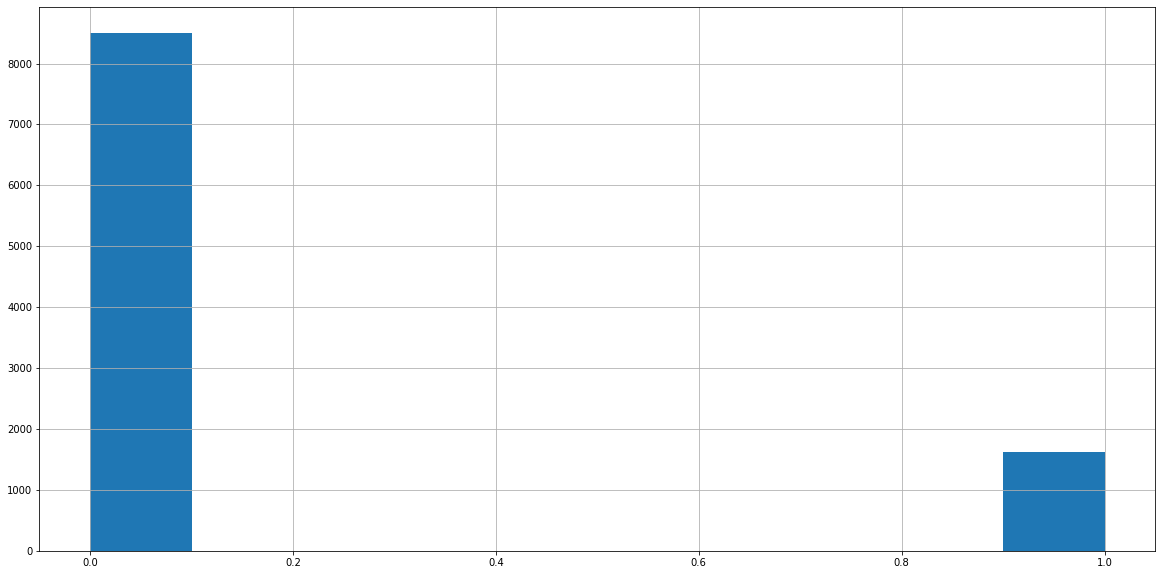

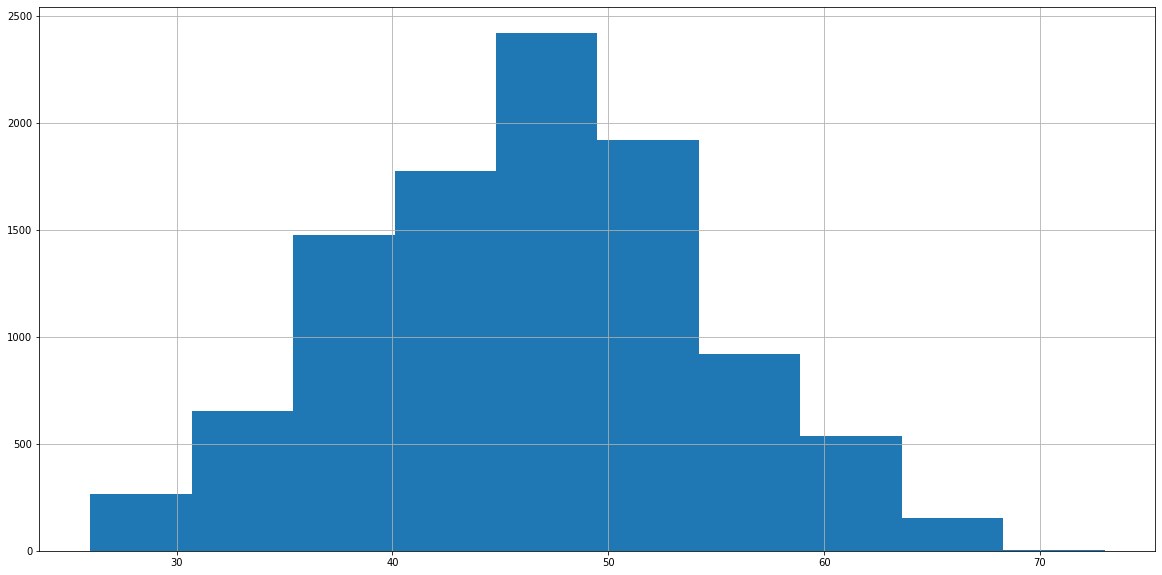

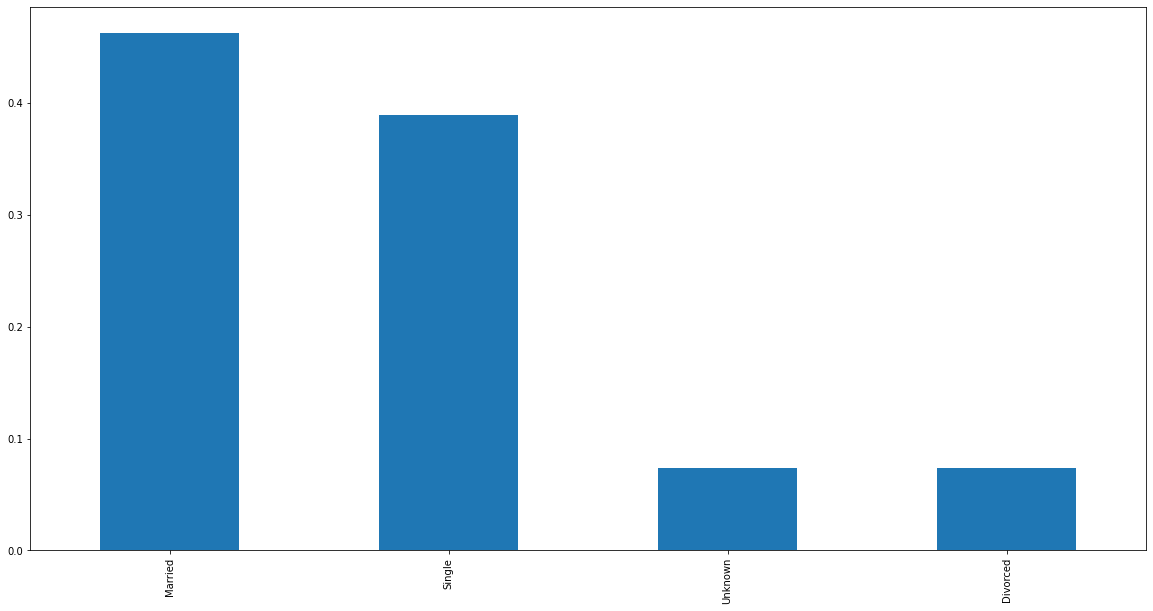

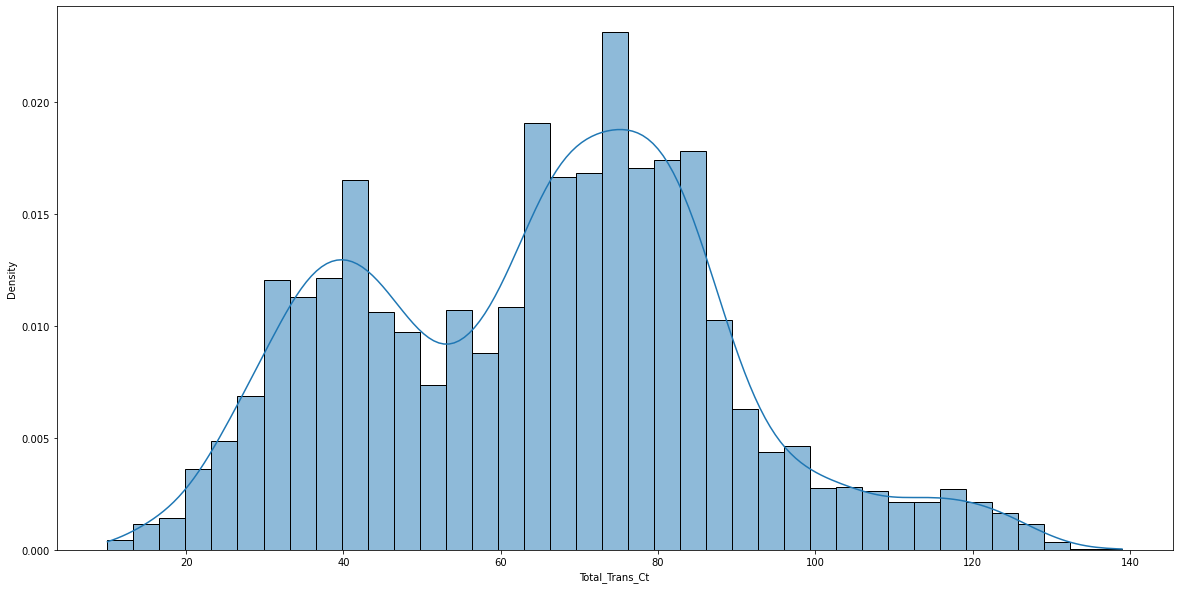

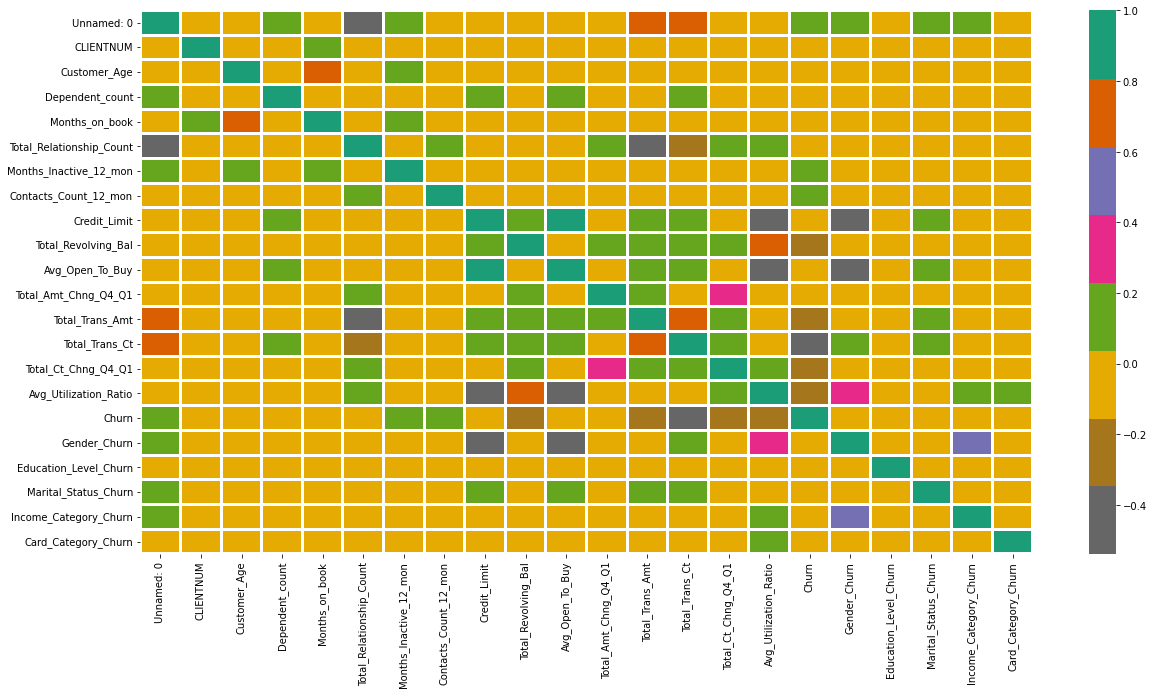

In [57]:
perform_eda(df_encode)

In [58]:
X_train, X_test, y_train, y_test= perform_feature_engineering(df_encode, 'Churn')
X_train.Marital_Status_Churn.head

<bound method NDFrame.head of 415     0.151269
3749    0.169414
9295    0.172230
8290    0.151269
7672    0.169414
          ...   
5734    0.169414
5191    0.161765
5390    0.172230
860     0.169414
7270    0.169414
Name: Marital_Status_Churn, Length: 7088, dtype: float64>

c:\Users\Joko\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


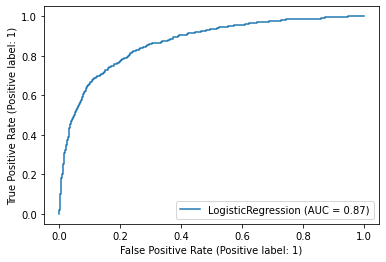

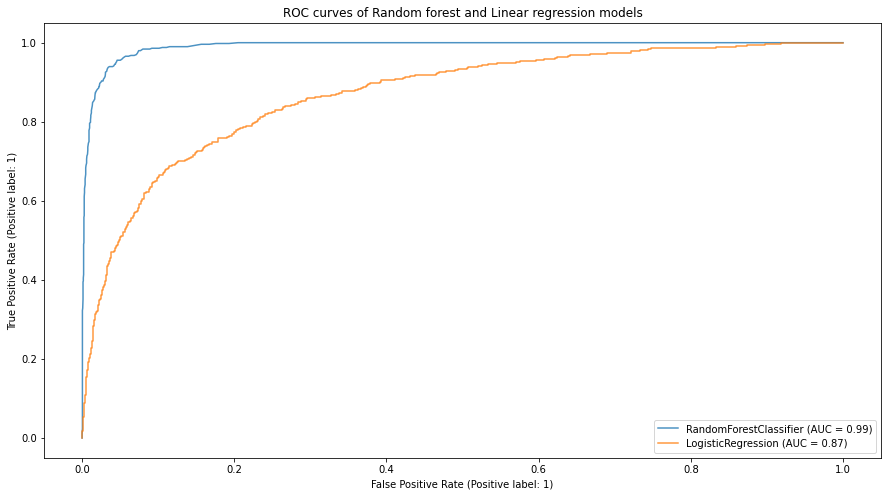

In [59]:
rfc_path = 'models/rfc_model.pkl'
lr_path = 'models/lrc_model.pkl'

train_models(X_train, X_test,y_train,y_test, rfc_path, lr_path)

In [61]:
rfc_model = joblib.load(rfc_path)
lr_model = joblib.load(lr_path)

y_train_preds_lr = lr_model.predict(X_train)
y_train_preds_rf = rfc_model.predict(X_train)
y_test_preds_lr = lr_model.predict(X_test)
y_test_preds_rf = rfc_model.predict(X_test)

<Figure size 432x288 with 0 Axes>

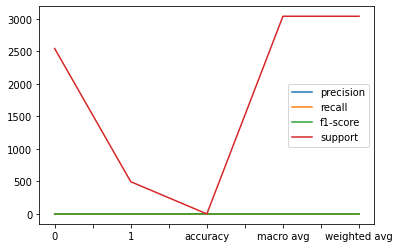

<Figure size 432x288 with 0 Axes>

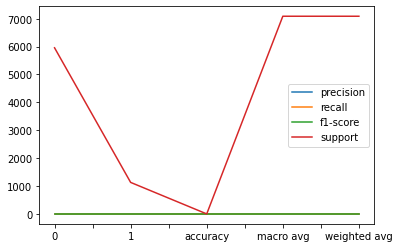

<Figure size 432x288 with 0 Axes>

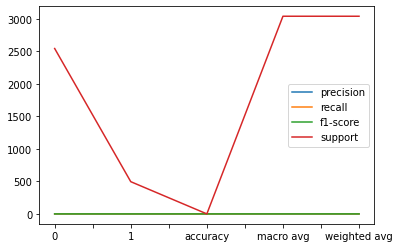

<Figure size 432x288 with 0 Axes>

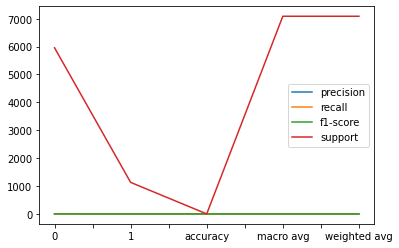

In [62]:
classification_report_image(y_train,
                            y_test,
                            y_train_preds_lr,
                            y_train_preds_rf,
                            y_test_preds_lr,
                            y_test_preds_rf
                            )


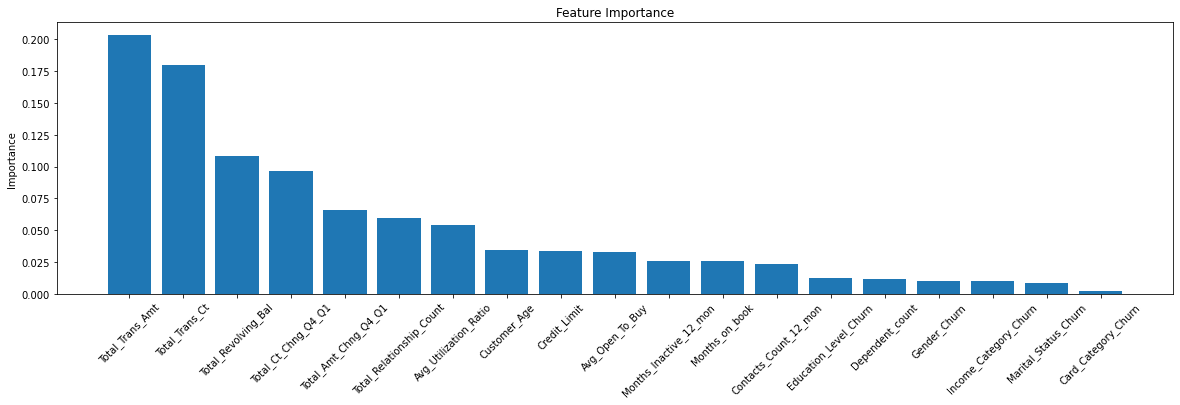

In [63]:
X_data = pd.concat([X_train, X_test])
rfc_report_path = 'images/results/feature_importance.png'
feature_importance_plot(rfc_model, X_data, rfc_report_path)